In [1]:
import ete3
import os
import re
import treeCl
import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS
from scipy.stats import wilcoxon, ttest_ind
import re
import multiprocessing
import subprocess
#import plotly
#import plotly.plotly as ptl
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

%cd /work/site_rate/hug_et_al

DEBUG:matplotlib:CACHEDIR=/Users/thiberio/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/thiberio/.matplotlib/fontList.json
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


/work/site_rate/hug_et_al


In [15]:
tree = ete3.Tree('ribosomal_concat_ml_tree-regular_support.tre')
bipartitions   = []
branch_lengths = []
for node in tree.traverse():
    if node.is_leaf() or node.is_root():
        continue
    bipartitions.append(set(node.get_leaf_names()))
    branch_lengths.append(node.dist)

In [56]:
less_than_10_percent = []
for category in range(1, 13):
    print category
    ufboot = open('categories/%i.boot.ufboot' % category).read().split('\n')
    ufboot.pop()
    incompatibles = []
    for replicate in ufboot:
        tmp_tree = ete3.Tree(replicate)
        tmp_bipartitions = [set(node.get_leaf_names())
                            for node in tmp_tree.traverse()
                            if not node.is_leaf() and not node.is_root()]
        for (index, bipartition1) in enumerate(bipartitions):
            for bipartition2 in tmp_bipartitions:
                if bipartition1.isdisjoint(bipartition2):
                    continue
                elif bipartition1.issubset(bipartition2) or bipartition1.issubset(bipartition2):
                    continue
                else:
                    incompatibles.append(index)
                    break

    incompatibility_freq = Counter(incompatibles)
    
    less_than_10_percent.append([])
    for i,j in incompatibility_freq.items():
        if j <= 200:
            less_than_10_percent[-1].append(branch_lengths[i])

1
2
3
4
5
6
7
8
9
10
11
12


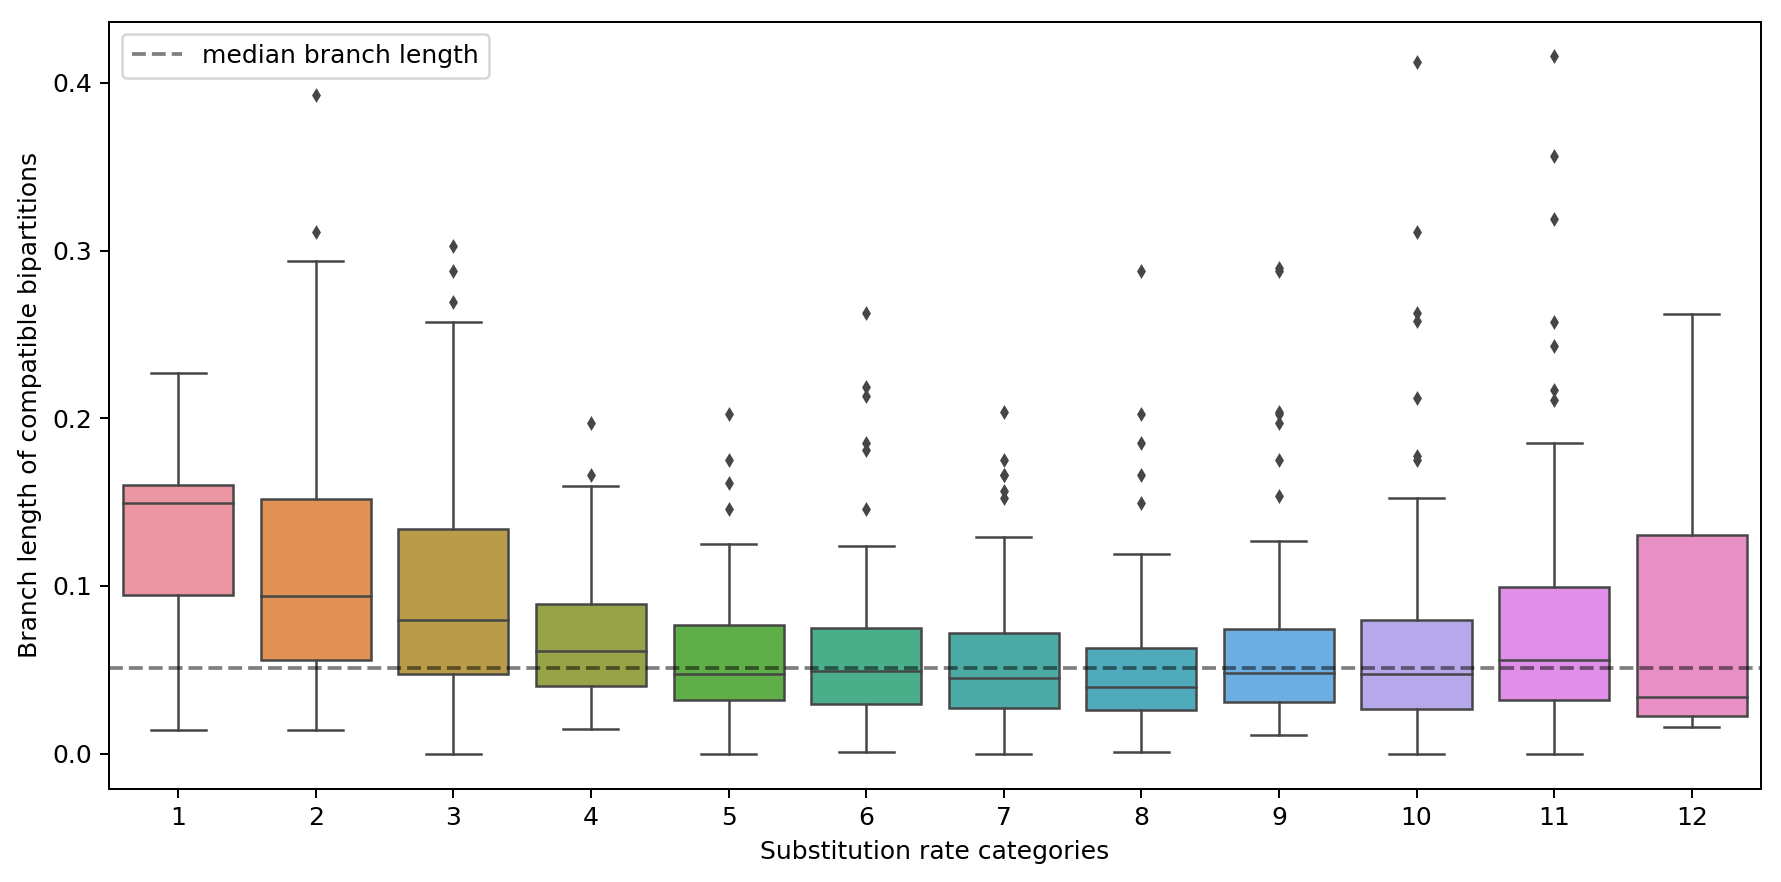

In [86]:
fig, ax = plt.subplots(dpi=180, figsize=(10,5))
sns.boxplot(data=less_than_10_percent, ax=ax, linewidth=1, fliersize=3)
ax.plot(ax.get_xlim(), [np.median(branch_lengths), np.median(branch_lengths)], '--',
        c='k', alpha=0.5, label='median branch length')
ax.set_xticklabels(range(1,13))
ax.set_xlabel('Substitution rate categories')
ax.set_ylabel('Branch length of compatible bipartitions')
ax.legend()
fig.tight_layout()

In [70]:
ax.get_xlim()

(-0.5, 11.5)

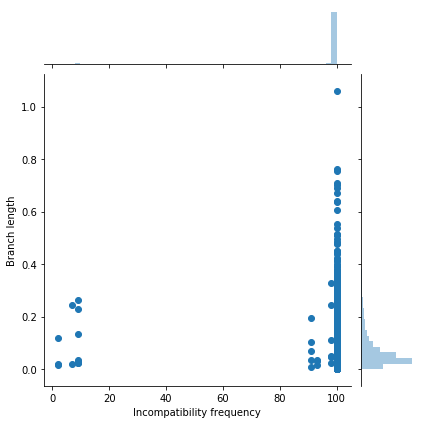

In [47]:
x = []
y = []
for i, j in incompatibility_freq.items():
    x.append(j)
    y.append(branch_lengths[i])

sns.jointplot(x=pd.Series(data=x, name='Incompatibility frequency'),
              y=pd.Series(data=y, name='Branch length'))

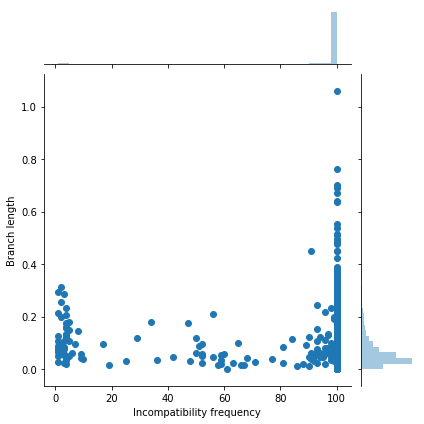

In [48]:
ufboot = open('categories/2.boot.ufboot').read().split('\n')
ufboot.pop()
incompatibles = []
for replicate in random.sample(ufboot, 100):
    tmp_tree = ete3.Tree(replicate)
    tmp_bipartitions = [set(node.get_leaf_names())
                        for node in tmp_tree.traverse()
                        if not node.is_leaf() and not node.is_root()]
    for (index, bipartition1) in enumerate(bipartitions):
        for bipartition2 in tmp_bipartitions:
            if bipartition1.isdisjoint(bipartition2):
                continue
            elif bipartition1.issubset(bipartition2) or bipartition1.issubset(bipartition2):
                continue
            else:
                incompatibles.append(index)
                break

incompatibility_freq = Counter(incompatibles)

x = []
y = []
for i, j in incompatibility_freq.items():
    x.append(j)
    y.append(branch_lengths[i])

sns.jointplot(x=pd.Series(data=x, name='Incompatibility frequency'),
              y=pd.Series(data=y, name='Branch length'))

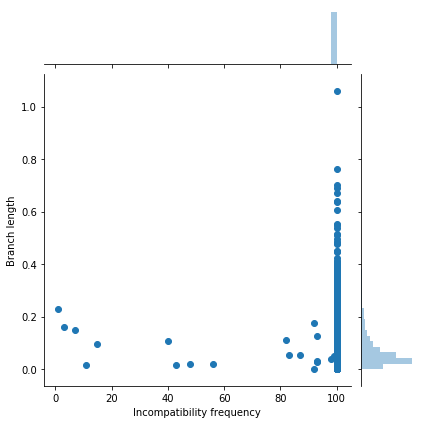

In [46]:
ufboot = open('categories/1.boot.ufboot').read().split('\n')
ufboot.pop()
incompatibles = []
for replicate in random.sample(ufboot, 100):
    tmp_tree = ete3.Tree(replicate)
    tmp_bipartitions = [set(node.get_leaf_names())
                        for node in tmp_tree.traverse()
                        if not node.is_leaf() and not node.is_root()]
    for (index, bipartition1) in enumerate(bipartitions):
        for bipartition2 in tmp_bipartitions:
            if bipartition1.isdisjoint(bipartition2):
                continue
            elif bipartition1.issubset(bipartition2) or bipartition1.issubset(bipartition2):
                continue
            else:
                incompatibles.append(index)
                break

incompatibility_freq = Counter(incompatibles)

x = []
y = []
for i, j in incompatibility_freq.items():
    x.append(j)
    y.append(branch_lengths[i])

sns.jointplot(x=pd.Series(data=x, name='Incompatibility frequency'),
              y=pd.Series(data=y, name='Branch length'))

In [11]:
tree = ete3.Tree('ribosomal_concat_ml_tree-regular_support.tre')
bipartition_df = pd.DataFrame(columns=tree.get_leaf_names())
bipartition_df['branch_length'] = pd.Series()

counter = 0
for node in tree.traverse():
    if node.is_leaf() or node.is_root():
        continue
    counter += 1
    bipartition_df.loc[counter, node.get_leaf_names()] = 1

KeyboardInterrupt: 

In [10]:
bipartition_df

,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Kluyveromyces_thermotolerans_strain_CBS_6340,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Naumovozyma_castellii_AS_2.2404_CBS_4309,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Zygosaccharomyces_rouxii_CBS_732,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Vanderwaltozyma_polyspora_DSM_70294_Kpol,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Tetrapisispora_phaffii_van_der_Walt_Y_89_CBS_4417,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Eremothecium_cymbalariae_DBVPG7215,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Torulaspora_delbrueckii_Wallerstein_129_CBS_1146,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_mitosporic_Saccharomycetales_Candida_glabrata_strain_CBS138,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Saccharomyces_cerevisiae,Eukaryota_Opisthokonta_Fungi_Dikarya_Ascomycota_saccharomyceta_Saccharomycotina_Saccharomycetes_Saccharomycetales_Saccharomycetaceae_Kluyveromyces_lactis_NRRL_Y_1140,...,Bacteria_CPR_CPR1_GWA2_CPR1_42_17,Bacteria_CPR_Dojkabacteria_WS6_GWE1_WS6_34_7,Bacteria_CPR_Doykabacteria_WS6_RIFOXYB1_FULL_WS6_33_14,Bacteria_CPR_Doykabacteria_WS6_RIFOXYB1_FULL_WS6_33_15,Bacteria_CPR_Doykabacteria_WS6_BJP_IG2158_WS6_35_49,Bacteria_CPR_Dojkabacteria_WS6_GWC2_WS6_36_7,Bacteria_CPR_Dojkabacteria_WS6_GWF1_WS6_35_23_partial,Bacteria_CPR_Dojkabacteria_WS6_GWA2_WS6_37_6,Bacteria_Wirthbacteria_CG2_30_FULL_Wirthbacteria_54_11,branch_length
1,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
trees = []
names = []
random.seed(12345)
for category in range(1,13):
    ufboot = open('categories/%i.boot.ufboot' % category).read().split('\n')
    ufboot.pop()
    trees.extend(random.sample(ufboot, 100))
    names.extend(['rate_%i' % category]*100)
trees.append(open('ribosomal_concat_ml_tree-regular_support.tre').read().strip())
names.append('Full tree')

In [ ]:
out = open('rf_trees_individual_cats.treelist', 'w')
out.write('\n'.join(trees))
out.close()

subprocess.call(['iqtree', '-t', 'rf_trees_individual_cats.treelist', '-rf_all', '-nt', '15'])

In [ ]:
distances = []
for line in open('rf_trees_individual_cats.treelist.rfdist').readlines()[1:]:
    line = line.split()[1:]
    distances.append([float(value) for value in line])

df = pd.DataFrame(index=names, columns=names, data=distances)

In [ ]:
df.info()

In [ ]:
intra_distances = []
for category in range(1,13):
    category_indexes = df.index[df.index == 'rate_%i' % category]
    tmp_df = df.loc[df.index=='rate_%i' % category, df.columns=='rate_%i' % category].copy()
    intra_distances.append(squareform(tmp_df.values))

fig, axs = plt.subplots(nrows=2, sharex=True, dpi=180, figsize=(10,8))
sns.boxplot(x=range(1,13), y=intra_distances, ax=axs[0])
axs[0].set_ylabel('Distances within rate category trees')

whole_alignment_indexes = df.index[df.index.str.startswith('Full tree')]
distances_to_whole_aln = []
for category in range(1,13):
    category_indexes = df.index[df.index == 'rate_%i' % category]
    tmp_df = df.loc[df.index=='rate_%i' % category, df.columns=='Full tree'].copy()
    distances_to_whole_aln.append(tmp_df.values.flatten())
    
sns.boxplot(x=range(1,13), y=distances_to_whole_aln, ax=axs[1])
axs[1].set_ylabel('Distances to whole alignment trees')
axs[1].set_xlabel('Rate categories')

fig.tight_layout()

In [ ]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=6)
coords    = embedding.fit_transform(df.values)
coords_df = pd.DataFrame(data=coords, columns='x y'.split(), index=df.index)
        
coords_df['gene_type'] = coords_df.index.tolist()
coords_df.loc[coords_df['gene_type'] == 'Full tree', 'gene_type'] = 'whole alignment'

In [ ]:
markers = {'rate_%i' % num:'o' for num in range(1,7)}
markers.update({'rate_%i' % num:'s' for num in range(7,13)})
markers['whole alignment'] = 'X'
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
sns.scatterplot(x='x', y='y', hue='gene_type',
                style='gene_type', data=coords_df,
                ax=ax, s=100, palette="Set2",
                markers=markers, alpha=1)
ax.set_xlabel('')
ax.set_ylabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], markerscale=1.5,
          loc=10, bbox_to_anchor=(0.5, -0.1), ncol=7, frameon=False)

In [ ]:
for filename in os.listdir('selected_categories/'):
    if not filename.endswith('.boottrees'):
        continue
    ufboot = open('selected_categories/%s' % filename).read().split('\n')
    ufboot.pop()
    trees.extend(ufboot)
    names.extend([filename.replace('.aln.boottrees', '')]*len(ufboot))

In [ ]:
out = open('rf_trees.treelist', 'w')
out.write('\n'.join(trees))
out.close()

subprocess.call(['iqtree', '-nt', '15', '-redo',
                 '-t', 'rf_trees.treelist', '-rf_all'])

In [ ]:
distances = []
for line in open('rf_trees.treelist.rfdist').readlines()[1:]:
    line = line.split()[1:]
    distances.append([float(value) for value in line])

df = pd.DataFrame(index=names, columns=names, data=distances)

In [ ]:
intra_distances = pd.DataFrame(columns=['tree group', 'distance'])
for category in ['missing-11_12', 'missing-1_2', 'missing-1_2_11_12', 'ribosomal_concat.fasta.boottrees']:
    category_indexes = df.index[df.index == category]
    tmp_df = df.loc[df.index== category, df.columns== category].copy()
    condensed_df = squareform(tmp_df.values)
    intra_distances = intra_distances.append(
        pd.DataFrame(
            data=zip([category]*len(condensed_df), condensed_df), 
            columns=['tree group', 'distance']),
        ignore_index=True)

fig, axs = plt.subplots(nrows=2, sharex=False, dpi=180, figsize=(10,8))
sns.boxplot(x='tree group', y='distance', data=intra_distances, ax=axs[0])
axs[0].set_ylabel('Distances within rate category trees')

whole_alignment_indexes = df.index[df.index.str.startswith('ribosomal_concat_ml_tree')]
distances_to_whole_aln = pd.DataFrame(columns=['tree group', 'distance'])
for category in ['missing-11_12', 'missing-1_2', 'missing-1_2_11_12', 'ribosomal_concat.fasta.boottrees']:
    category_indexes = df.index[df.index == category]
    tmp_df = df.loc[df.index==category, df.columns=='ribosomal_concat_ml_tree'].copy()
    condensed_df = tmp_df.values.flatten()
    distances_to_whole_aln = distances_to_whole_aln.append(pd.DataFrame(
            data=zip([category]*len(condensed_df), condensed_df), 
            columns=['tree group', 'distance']),
        ignore_index=True)
    
sns.boxplot(x='tree group', y='distance', data=distances_to_whole_aln, ax=axs[1])
axs[1].set_ylabel('Distances to whole alignment trees')
axs[1].set_xlabel('Rate categories')

fig.tight_layout()

In [ ]:
from scipy.stats import wilcoxon
for group1, group2 in combinations(intra_distances['tree group'].unique(), 2):
    i = intra_distances.distance[intra_distances['tree group'] == group1].values
    j = intra_distances.distance[intra_distances['tree group'] == group2].values
    if len(i) > len(j):
        i = i[:len(j)]
    else:
        j = j[:len(i)]
    print '%s VS %s: %f' % (group1, group2, ttest_ind(i, j).pvalue)

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(intra_distances.distance[intra_distances['tree group'] == 'missing-1_2'].values,
            ax=ax, shade=True, label='missing-1_2')
sns.kdeplot(intra_distances.distance[intra_distances['tree group'] == 'ribosomal_concat.fasta.boottrees'].values,
            ax=ax, shade=True, label='ribosomal_concat.fasta.boottrees')

In [ ]:
for group1, group2 in combinations(distances_to_whole_aln['tree group'].unique(), 2):
    i = distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == group1].values
    j = distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == group2].values
    if len(i) > len(j):
        i = i[:len(j)]
    else:
        j = j[:len(i)]
    print '%s VS %s: %f' % (group1, group2, ttest_ind(i, j).pvalue)

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == 'missing-1_2'].values,
            ax=ax, shade=True, label='missing-1_2')
sns.kdeplot(distances_to_whole_aln.distance[distances_to_whole_aln['tree group'] == 'ribosomal_concat.fasta.boottrees'].values,
            ax=ax, shade=True, label='ribosomal_concat.fasta.boottrees')


In [ ]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=6)
coords    = embedding.fit_transform(df.values)
coords_df = pd.DataFrame(data=coords, columns='x y'.split(), index=df.index)
        
coords_df['gene_type'] = coords_df.index.tolist()
coords_df.loc[coords_df['gene_type'] == 'ribosomal_concat_ml_tree', 'gene_type'] = 'whole alignment'

In [ ]:
markers = {num:'o' for num in ['missing-11_12', 'missing-1_2']}
markers['missing-1_2_11_12'] = '^'
markers['ribosomal_concat.fasta.boottrees'] = 's'
markers['whole alignment'] = 'X'
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
sns.scatterplot(x='x', y='y', hue='gene_type',
                style='gene_type', data=coords_df,
                ax=ax, s=80, palette="Set2",
                markers=markers, alpha=1)
ax.set_xlabel('')
ax.set_ylabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], markerscale=1.5,
          loc=10, bbox_to_anchor=(0.5, -0.1), ncol=5, frameon=False)

In [ ]:
cmap        = plt.get_cmap('rainbow')
color_range = ['#%02x%02x%02x' % cmap(value, bytes=True)[:3] for value in np.linspace(0, 1, 6)]
data        = []
marker_shapes = ['circle', 'square', 'triangle-up', 'diamond', 'star']
for gene_type, (shape,color) in zip(coords_df.gene_type.unique(), product(marker_shapes, color_range)):
    tmp    = coords_df[coords_df.gene_type == gene_type]
    
    data.append(
        go.Scatter(x=tmp.x.values, y=tmp.y.values, mode='markers', text=tmp.index,
               name=gene_type, hoverinfo='text', showlegend=True,
               marker=dict(size=[20 if index.endswith('.bmge') or index.startswith('missing') else 10
                                   for index in tmp.index],color=color, opacity=.7,
                           symbol=['star' if index.endswith('.bmge') or index.startswith('missing') else shape
                                   for index in tmp.index])
        )
    )
layout    = go.Layout(title='Geodesic distances', hovermode='closest', width=1200, height=1000)
fig       = go.Figure(data=data, layout=layout)
iplot(fig)